<a href="https://colab.research.google.com/github/TomiMalamud/autovi-anomaly-detection/blob/main/AutoIV_Dataset_tank_screw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive
import matplotlib.pyplot as plt
import random
from PIL import Image
import numpy as np

# Set up base directory
base_dir = '/content/drive/MyDrive/tank_screw'

def inspect_directory(directory):
    print(f"Inspecting directory: {directory}")
    subdirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    print(f"Subdirectories: {subdirs}")

    for subdir in subdirs:
        subdir_path = os.path.join(directory, subdir)
        files = os.listdir(subdir_path)
        print(f"  {subdir}: {len(files)} files")

        if len(files) > 0:
            print(f"  Sample filenames in {subdir}:")
            for filename in random.sample(files, min(5, len(files))):
                print(f"    {filename}")

def display_random_images(directory, num_images=5):
    all_image_paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith('.jpg'):
                all_image_paths.append(os.path.join(root, file))

    if not all_image_paths:
        print(f"No images found in {directory}")
        return

    sampled_paths = random.sample(all_image_paths, min(num_images, len(all_image_paths)))

    fig, axes = plt.subplots(1, len(sampled_paths), figsize=(20, 4))
    if len(sampled_paths) == 1:
        axes = [axes]

    for ax, img_path in zip(axes, sampled_paths):
        img = Image.open(img_path)
        ax.imshow(np.array(img))
        ax.axis('off')
        ax.set_title(os.path.basename(os.path.dirname(img_path)) + '\n' + os.path.basename(img_path))

    plt.tight_layout()
    plt.show()

Inspecting directory: /content/drive/MyDrive/tank_screw/train
Subdirectories: ['good']
  good: 318 files
  Sample filenames in good:
    0292.jpg
    0216.jpg
    0105.jpg
    0304.jpg
    0155.jpg

Displaying random images from train directory:


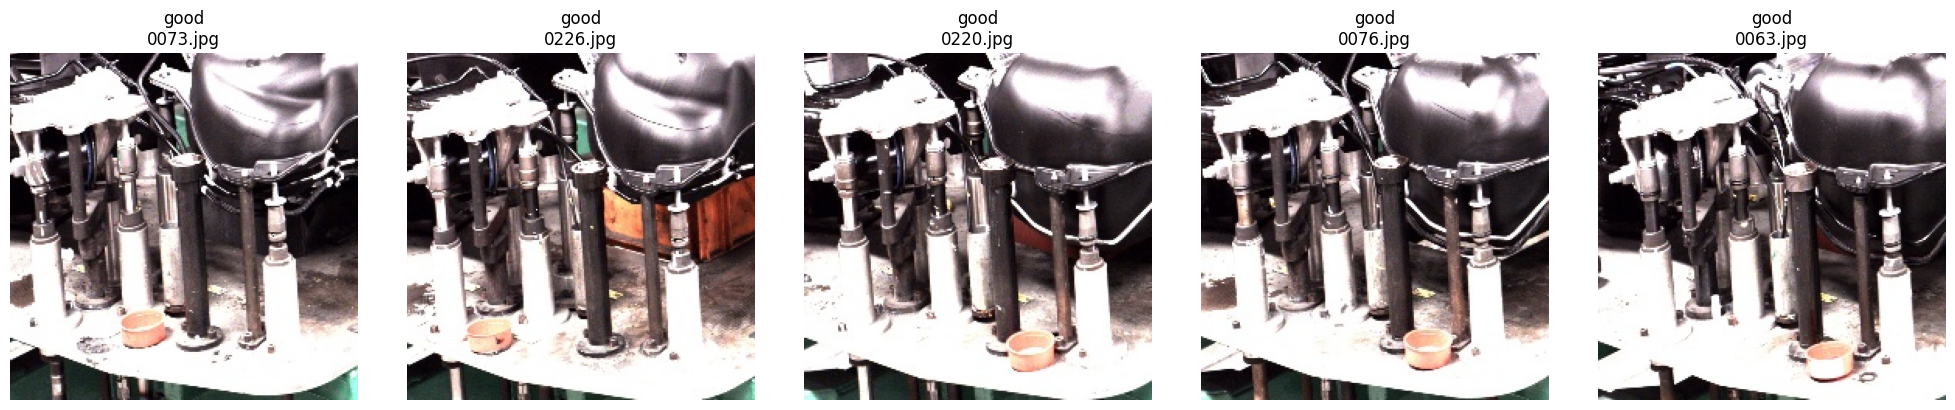



Inspecting directory: /content/drive/MyDrive/tank_screw/test
Subdirectories: ['missing', 'good']
  missing: 95 files
  Sample filenames in missing:
    0075.jpg
    0034.jpg
    0077.jpg
    0023.jpg
    0084.jpg
  good: 318 files
  Sample filenames in good:
    0238.jpg
    0001.jpg
    0189.jpg
    0089.jpg
    0300.jpg

Displaying random images from test directory:


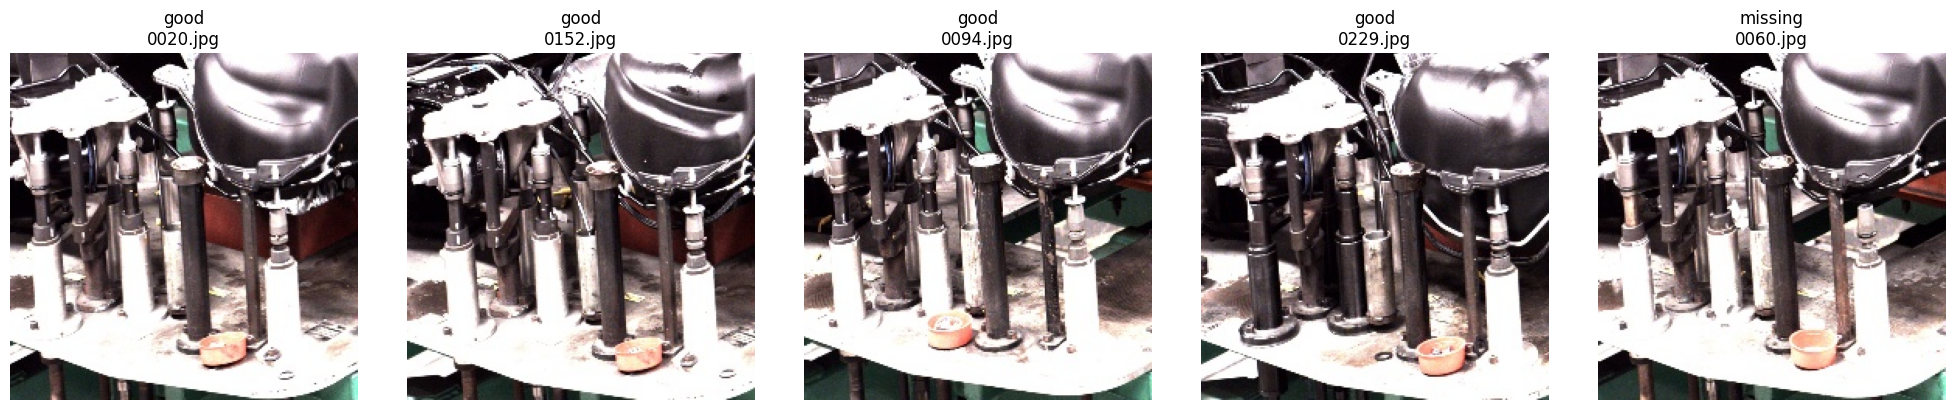

In [ ]:
# Inspect train and test directories
for dir_name in ['train', 'test']:
    dir_path = os.path.join(base_dir, dir_name)
    inspect_directory(dir_path)
    print(f"\nDisplaying random images from {dir_name} directory:")
    display_random_images(dir_path)
    print("\n" + "="*50 + "\n")

In [ ]:
import json
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Load and preprocess data
def load_data(data_dir):
    image_data = []
    labels = []

    for filename in sorted(os.listdir(data_dir)):
        if filename.endswith('.jpg'):
            img_path = os.path.join(data_dir, filename)
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            image_data.append(img_array)
            labels.append(0 if 'good' in data_dir else 1)  # 0 for 'good', 1 for 'missing'

    return np.array(image_data), np.array(labels)

# Load all data
good_data, good_labels = load_data('/content/drive/MyDrive/tank_screw/train/good')
missing_data, missing_labels = load_data('/content/drive/MyDrive/tank_screw/test/missing')

print(f"Number of 'good' samples: {len(good_labels)}")
print(f"Number of 'missing' samples: {len(missing_labels)}")

# Combine and shuffle the data
all_data = np.concatenate((good_data, missing_data))
all_labels = np.concatenate((good_labels, missing_labels))

# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(all_data, all_labels, test_size=0.2, stratify=all_labels, random_state=42)

# Normalize the data
train_data = train_data / 255.0
test_data = test_data / 255.0

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Create model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Calculate class weights
total_samples = len(train_labels)
n_positive = sum(train_labels)
n_negative = total_samples - n_positive
class_weight = {0: (1 / n_negative) * (total_samples / 2.0), 1: (1 / n_positive) * (total_samples / 2.0)}

# Train model
history = model.fit(
    datagen.flow(train_data, train_labels, batch_size=16, subset='training'),
    validation_data=datagen.flow(train_data, train_labels, batch_size=16, subset='validation'),
    epochs=50,
    class_weight=class_weight
)

# Evaluate model
test_loss, test_accuracy = model.evaluate(test_data, test_labels)
print(f"Test accuracy: {test_accuracy}")

# Save model
model.save('tank_screw_model.h5')

Number of 'good' samples: 318
Number of 'missing' samples: 95
9406464/9406464 [==============================] - 0s 0us/step


Epoch 1/50
17/17 [==============================] - 24s 1s/step - loss: 1.3140 - accuracy: 0.4167 - val_loss: 0.4429 - val_accuracy: 0.8636
Epoch 2/50
17/17 [==============================] - 15s 892ms/step - loss: 0.9762 - accuracy: 0.5455 - val_loss: 0.8524 - val_accuracy: 0.2121
Epoch 3/50
17/17 [==============================] - 28s 2s/step - loss: 0.8079 - accuracy: 0.5455 - val_loss: 1.0406 - val_accuracy: 0.1364
Epoch 4/50
17/17 [==============================] - 19s 1s/step - loss: 0.7780 - accuracy: 0.5038 - val_loss: 0.6730 - val_accuracy: 0.5909
Epoch 5/50
17/17 [==============================] - 15s 902ms/step - loss: 0.7550 - accuracy: 0.4886 - val_loss: 0.8904 - val_accuracy: 0.1970
Epoch 6/50
17/17 [==============================] - 15s 898ms/step - loss: 0.6839 - accuracy: 0.6477 - val_loss: 0.6661 - val_accuracy: 0.6212
Epoch 7/50
17/17 [==============================] - 14s 774ms/step - loss: 0.6818 - accuracy: 0.6061 - val_loss: 0.5742 - val_accuracy: 0.7273
Epoch 8/

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3/3 [==============================] - 6s 1s/step


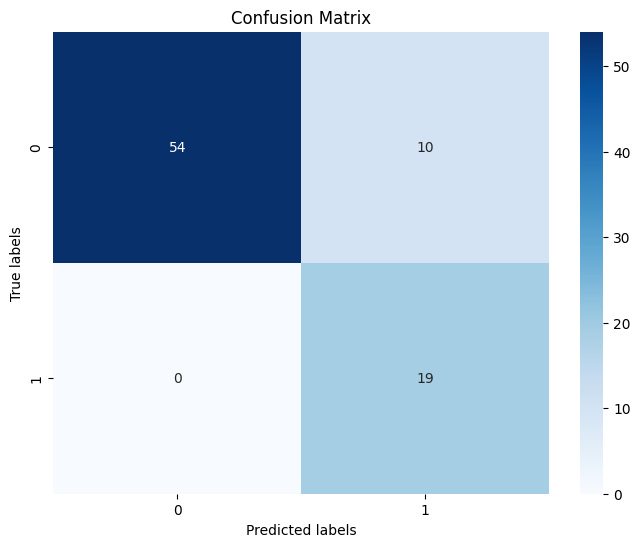

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


test_pred = model.predict(test_data)

# Convert predictions to labels
test_pred_labels = (test_pred > 0.5).astype(int)

# Create confusion matrix
cm = confusion_matrix(test_labels, test_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

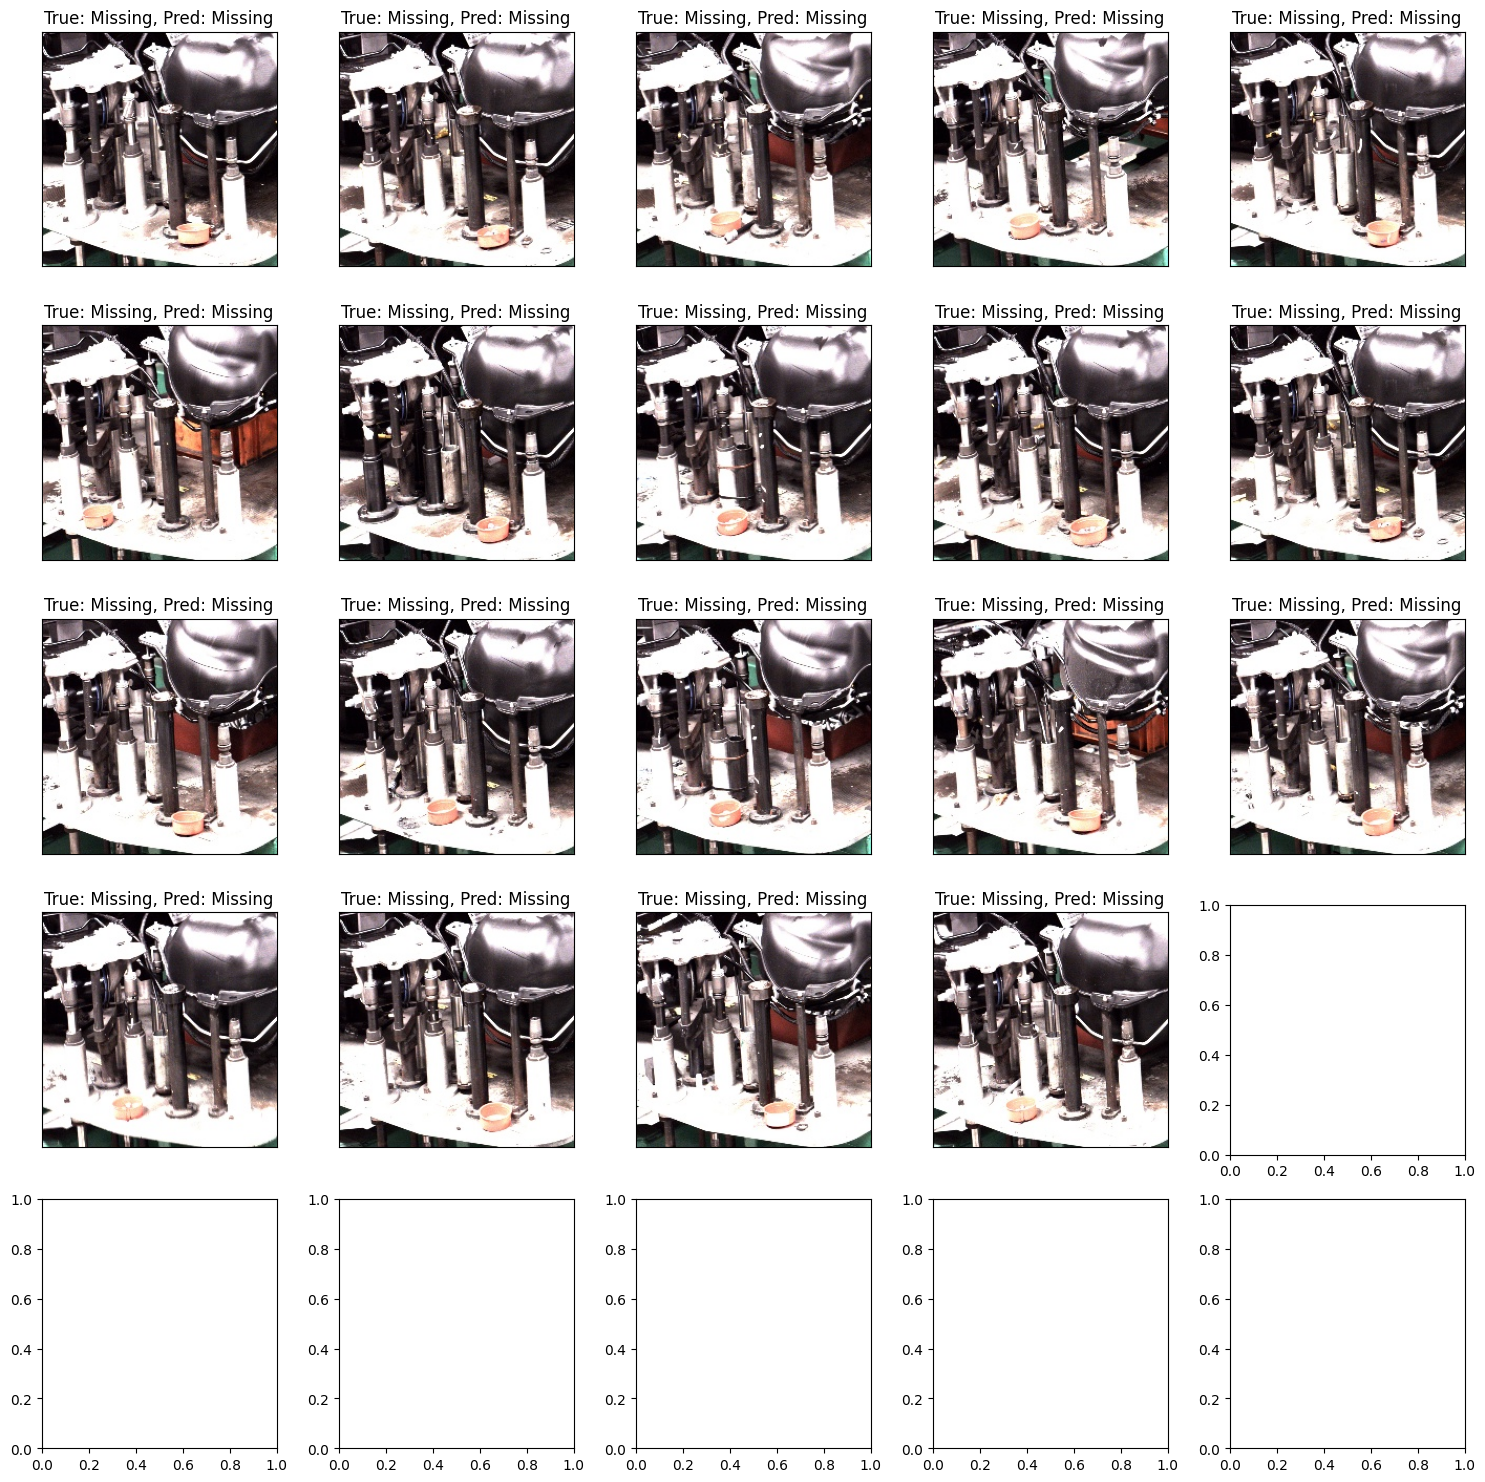

In [8]:
# Get the indices of 'missing' images in the test set
missing_indices = np.where(test_labels == 1)[0]

# Get the predicted labels for these images
missing_pred = test_pred_labels[missing_indices]

# Create a figure with 5 rows and 5 columns
fig, axs = plt.subplots(5, 5, figsize=(15, 15))

# Iterate over the 'missing' images and their predicted labels
for i, (idx, pred) in enumerate(zip(missing_indices[:25], missing_pred[:25])):
    # Get the image
    img = test_data[idx]

    # Get the true label
    true_label = 'Missing' if test_labels[idx] == 1 else 'Good'

    # Get the predicted label
    pred_label = 'Missing' if pred == 1 else 'Good'

    # Plot the image
    axs[i // 5, i % 5].imshow(img)

    # Set the title to include the true label and predicted label
    axs[i // 5, i % 5].set_title(f'True: {true_label}, Pred: {pred_label}')

    # Remove axis ticks
    axs[i // 5, i % 5].set_xticks([])
    axs[i // 5, i % 5].set_yticks([])

plt.tight_layout()
plt.show()

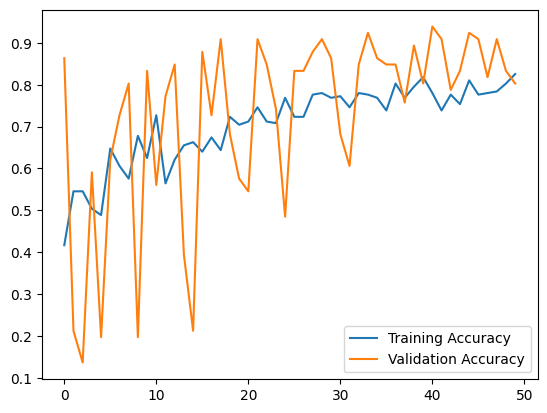

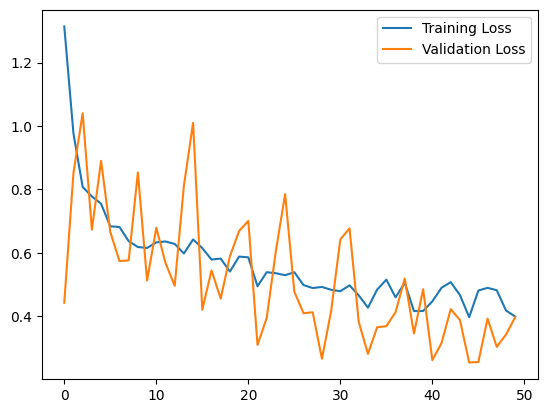

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


In [ ]:
import gradio as gr
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np

# Load the trained model
model = load_model('/content/tank_screw_model.h5')

def predict_image(img):
    # Preprocess the image
    img = tf.image.resize(img, (224, 224))
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
    img = tf.expand_dims(img, axis=0)

    # Make prediction
    prediction = model.predict(img)

    # Get the class label
    class_label = "Good" if prediction[0][0] < 0.5 else "Missing"

    # Get the confidence
    confidence = prediction[0][0] if class_label == "Missing" else 1 - prediction[0][0]

    return {class_label: float(confidence)}

# Create Gradio interface
iface = gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="numpy"),
    outputs=gr.Label(num_top_classes=2),
    title="Tank Screw Classifier",
    description="Upload an image of a tank screw to classify it as 'Good' or 'Missing'."
)

# Launch the interface
iface.launch()